**Author: Alex Allauzen**

This notebook contains code to generate the main results and figures of the paper "Experimental study of Neural ODE training with adaptive solver for dynamical systems modeling" presented at the 2nd NeurIPS [workshop on Deep Learning and Differential Equations](https://dlde-2022.github.io/). 



# Importing libraries

In [1]:
#######################################################
# Useful imports, preliminary commands, etc
#######################################################
import sys
import os
# Numpy and maths
import math
import numpy as np
from scipy.linalg import expm
# torch
import torch as th 
import torch.nn as nn 
from torch.nn  import functional as F 

# Lorenz generator
from lorenz_map import LorenzMap, scatterGraph

# Matplotlib and figures-related commands
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# figs helpers
from fig_utils import *

sns.color_palette("bright")

%matplotlib inline

# Loading the data

In [2]:
dname="./datasets/dataset1.np"
f = open(dname, 'rb') 
data = np.load(f)
T,d = data.shape
print("Shape of data:",T,d)


Shape of data: 5000 3


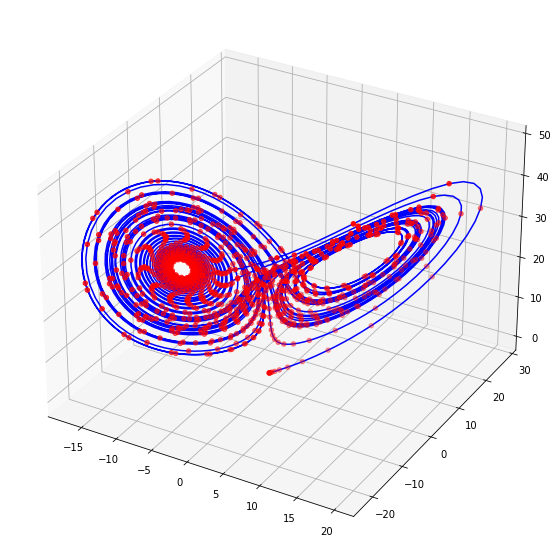

In [3]:
scatterGraph(data,mark_downsampling=5)

## Neural ODE

Here we use a simple Neural ODE implementation: we define the Neural ODE class (ODENet) and its methods needed for learning:
- This is a simple wrapper that relies on a external solver. Here we don't use the adjoint method. The solvers are implemented and provided in ode_utils
- Note that here the model is a simple feed forward model with 2 hidden layers, and $h$ is the hidden size.




In [4]:
from ode_utils import ODENet, euler_solve, generate_fehlberg

# Convert data to torch tensors
obs = th.DoubleTensor(data) # data in torch
T , d = obs.shape # number of time steps, dimension (=3)
print(T,d)
times_np = np.linspace(0,T-1,T)
print(times_np.shape)
z0 = obs[0]
times = th.from_numpy(times_np).to(z0)
print(times.shape)
print(times[-5:])

device = th.device("cuda" if th.cuda.is_available() else "cpu")
obs = obs.to(device)
z0 = z0.to(device)
times = times.to(device)
print("running on ", device)
Y = obs[1:]

5000 3
(5000,)
torch.Size([5000])
tensor([4995., 4996., 4997., 4998., 4999.], dtype=torch.float64)
running on  cpu


# Pre-trained baseline models 

Here we look at models trained with lbfgs and with the regular training strategy. 

In [5]:
!ls -lt models/*lbfgs* | grep batch

-rw-rw-r-- 1 allauzen allauzen 26455 nov.   6 18:31 models/model.fehlberg__batch_training.lr5e-4.100epochs.lbfgs


In [6]:
def model_recover(preds, logen): 
    """ Compute the Lorenz'63 prediction from an initial point"""
    T,d = preds.shape
    recover = np.zeros( (T,d) ) 
    recover[0]=preds[0]
    for i in range(T-1):
        tmp = logen.full_traj(init_pos=preds[i], nb_steps=100)
        recover[i+1] = tmp[-1]
    return recover

def error_in_time(a,b):
    """MSE per time step"""
    T,d = a.shape
    T2,d2 = b.shape
    assert(T==T2)
    assert(d==d2)
    return np.power(a-b,2).sum(axis=1)

## Batch training with Fehlberg method

In [7]:
# Load the model
#############################################
modelname="models/model.fehlberg__batch_training.lr5e-4.100epochs.lbfgs" 
#############################################
model = th.load(modelname, map_location=th.device('cpu')).double()
print(model)
m1 =model

ODENet(
  (nn): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [8]:
ztrain , steps = generate_fehlberg(obs[0],m1,Ntimes=T,max_step=10)
trainloss = F.mse_loss(ztrain,obs,reduction='sum')/(T-1)
print(trainloss)

tensor(481.9765, dtype=torch.float64, grad_fn=<DivBackward0>)


In [9]:
ztrain = ztrain.detach().numpy()
steps = steps.detach().numpy()

Save fig in ./figs/baseline_vs_data.pdf


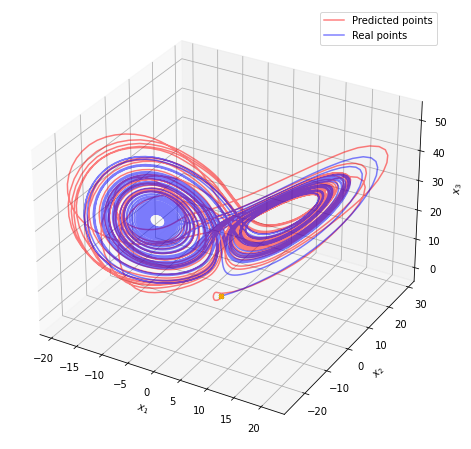

In [10]:
plot3D_compare(ztrain,data)
savefig("./figs/baseline_vs_data.pdf")
plt.show()


Save fig in ./figs/baseline_lorenz_3.pdf


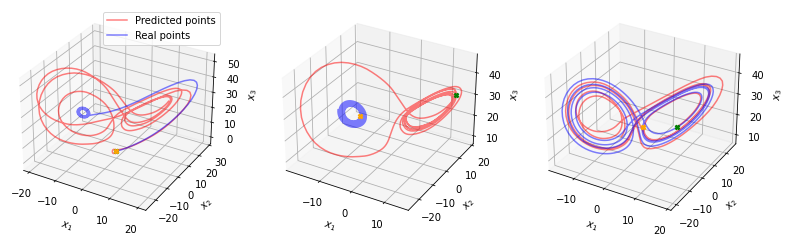

In [11]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
ax = fig.add_subplot(1, 3, 2, projection='3d')
MIN , MAX = 600, 1200 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax = fig.add_subplot(1, 3, 3, projection='3d')
MIN , MAX = 2000, 2600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")

#fig.suptitle("Learning Lorenz'63",fontsize=15)

savefig("./figs/baseline_lorenz_3.pdf")

./figs/baseline_lorenz_3.pdf already exists. Move it or change the file name


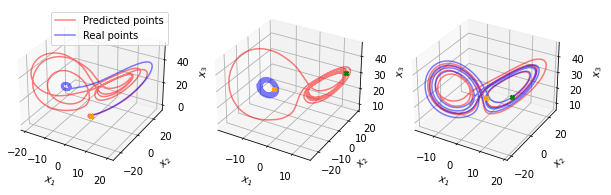

In [12]:
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
ax = fig.add_subplot(1, 3, 2, projection='3d')
MIN , MAX = 600, 1200 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax = fig.add_subplot(1, 3, 3, projection='3d')
MIN , MAX = 2000, 2600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")

#fig.suptitle("Learning Lorenz'63",fontsize=15)
savefig("./figs/baseline_lorenz_3.pdf")

Save fig in baseline_lorenz_1_3.pdf


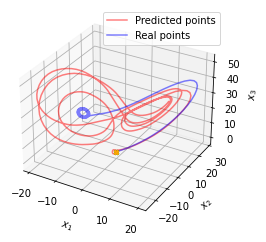

Save fig in baseline_lorenz_2_3.pdf


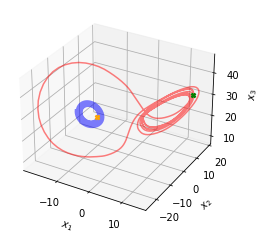

Save fig in baseline_lorenz_3_3.pdf


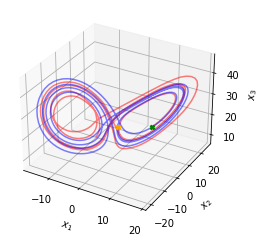

In [13]:
ax = plt.axes(projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
savefig("figs/baseline_lorenz_1_3.pdf", format="pdf")
plt.show()
ax = plt.axes(projection='3d')
MIN , MAX = 600,1200 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
savefig("figs/baseline_lorenz_2_3.pdf", format="pdf")
plt.show()
ax = plt.axes(projection='3d')
MIN , MAX = 2000,2600
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
savefig("figs/baseline_lorenz_3_3.pdf", format="pdf")

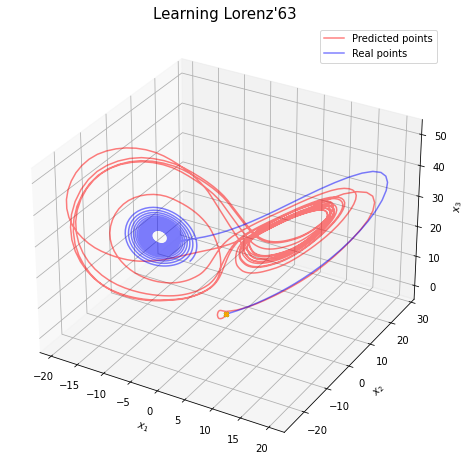

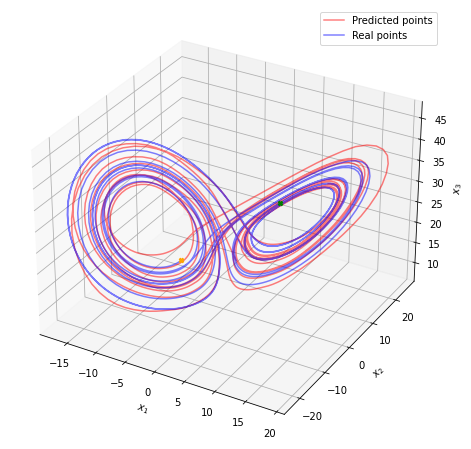

In [14]:
MIN , MAX = 0 , 1500 
plot3D_compare(ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="Learning Lorenz'63")
MIN , MAX = 1500 , 3000 
plot3D_compare(ztrain[MIN:MAX],data[MIN:MAX],markers=False)


In [15]:
genlo = LorenzMap(delta_t=1e-4)
rec = model_recover(ztrain,genlo)


Save fig in ./figs/baseline_time_series.pdf


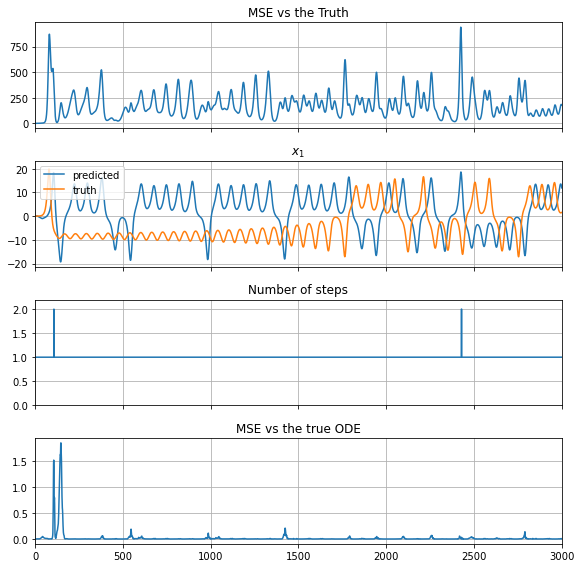

In [16]:
err = error_in_time(ztrain,data)
MIN , MAX = 0,3000
fig , axs = plt.subplots(4,1,figsize=(8,8),sharex=True)
axs[0].plot(err/3,label="MSE")
axs[0].set_title("MSE vs the Truth")

axs[1].plot(ztrain[:,0],label="predicted")
axs[1].plot(data[:,0],label="truth")
axs[1].legend()
axs[1].set_title("$x_1$")


axs[2].plot(steps,label="number of steps")
axs[2].set_ylim(0,2.2)
axs[2].set_title("Number of steps")

err2 = error_in_time(ztrain,rec)
axs[3].plot(err2/3,label="MSE")
axs[3].set_title("MSE vs the true ODE")
fig.tight_layout()
for ax in axs:
    ax.grid()
    ax.set_xlim(MIN,MAX)
savefig("./figs/baseline_time_series.pdf")

Save fig in ./figs/baseline_time_series_2x2.pdf


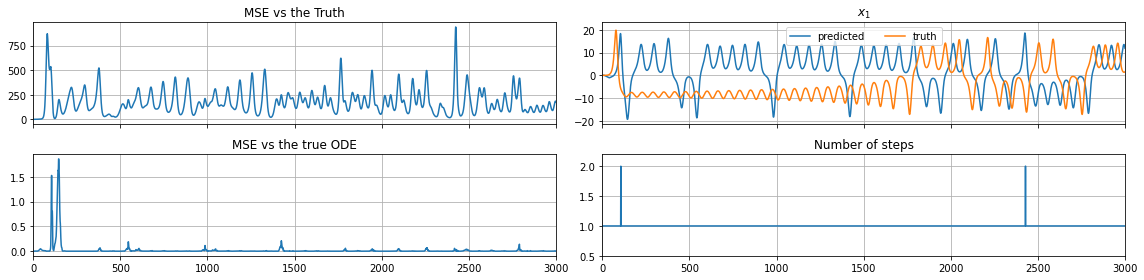

In [17]:
err = error_in_time(ztrain,data)
MIN , MAX = 0,3000
fig , axs = plt.subplots(2,2,figsize=(16,4),sharex=True)
axs[0,0].plot(err/3,label="MSE")
axs[0,0].set_title("MSE vs the Truth")
axs[0,0].set_xlim(MIN,MAX)

axs[1,1].plot(steps,label="number of steps")
axs[1,1].set_ylim(0.5,2.2)
axs[1,1].set_title("Number of steps")
    
axs[0,1].plot(ztrain[:,0],label="predicted")
axs[0,1].plot(data[:,0],label="truth")
axs[0,1].legend(ncol=2)
axs[0,1].set_title("$x_1$")



err2 = error_in_time(ztrain,rec)
axs[1,0].plot(err2/3,label="MSE")
axs[1,0].set_title("MSE vs the true ODE")

for r in axs:
    for c in r:
        c.grid()

fig.tight_layout()
savefig("./figs/baseline_time_series_2x2.pdf")

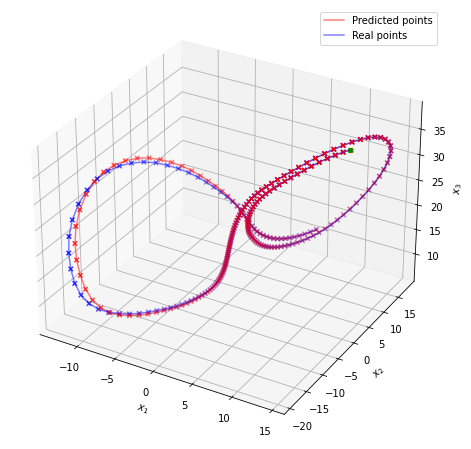

In [18]:
plot3D_compare(ztrain[3000:3200],rec[3000:3200],markers=True)


Save fig in ./figs/baseline_vs_recover_0_to_20.pdf


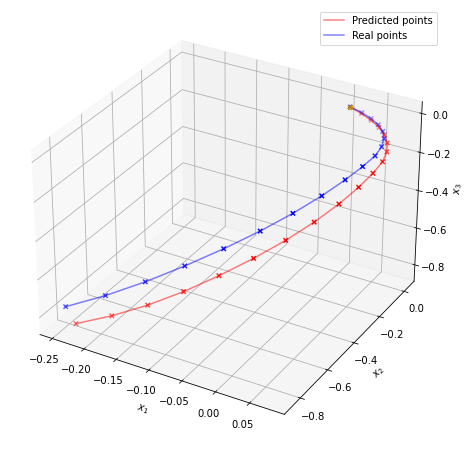

Save fig in ./figs/baseline_vs_data_0_to_20.pdf


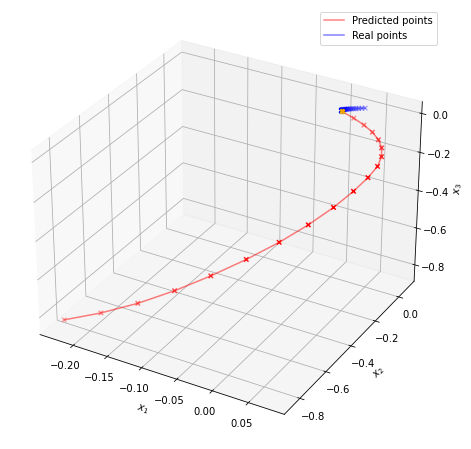

Save fig in ./figs/baseline_vs_recover_1000_to_1100.pdf


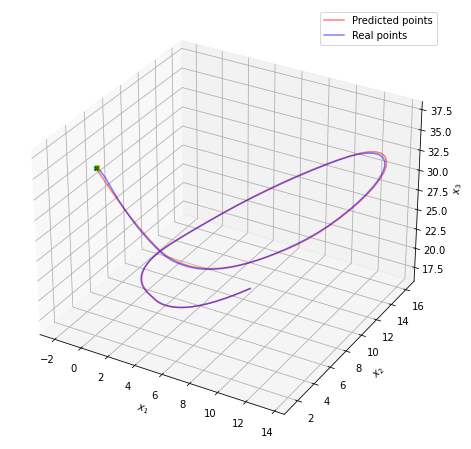

./figs/baseline_vs_recover_1000_to_1100.pdf already exists. Move it or change the file name


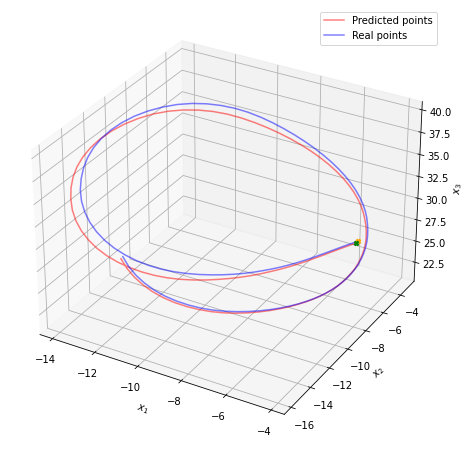

In [19]:
plot3D_compare(ztrain[:20],rec[:20],markers=True)
savefig("./figs/baseline_vs_recover_0_to_20.pdf", format="pdf")
plt.show()
plot3D_compare(ztrain[:20],data[:20],markers=True)
savefig("./figs/baseline_vs_data_0_to_20.pdf", format="pdf")
plt.show()

plot3D_compare(ztrain[1000:1100],rec[1000:1100])
savefig("./figs/baseline_vs_recover_1000_to_1100.pdf", format="pdf")
plt.show()

plot3D_compare(ztrain,rec,4000,4100)
savefig("./figs/baseline_vs_recover_1000_to_1100.pdf", format="pdf")
plt.show()

## Fehlberg training


In [20]:
!ls -lt models/*lbfgs* | grep -v batch

-rw-rw-r-- 1 allauzen allauzen 26455 nov.   6 18:32 models/model.fehlberg_training_freestep.lr1.200epochs.lbfgs


In [21]:
# Load the model
#############################################
modelname="models/model.fehlberg_training_freestep.lr1.200epochs.lbfgs" 
#############################################
model = th.load(modelname, map_location=th.device('cpu')).double()
print(model)
m1 =model

ODENet(
  (nn): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [22]:
ztrain , steps = generate_fehlberg(obs[0],m1,Ntimes=T,max_step=10)
trainloss = F.mse_loss(ztrain,obs,reduction='sum')/(T-1)
print(trainloss)

tensor(381.0790, dtype=torch.float64, grad_fn=<DivBackward0>)


In [23]:
ztrain = ztrain.detach().numpy()
steps = steps.detach().numpy()

Save fig in ./figs/fehlberg_vs_data.pdf


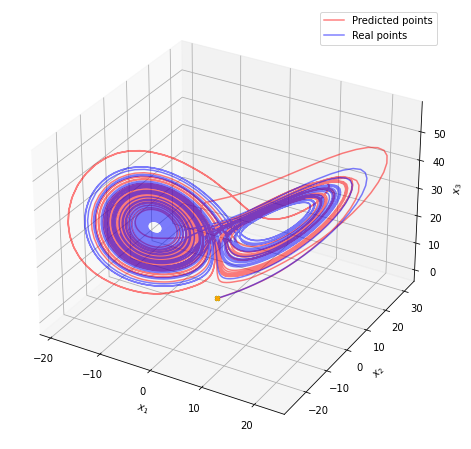

In [24]:
plot3D_compare(ztrain,data)
savefig("./figs/fehlberg_vs_data.pdf", format="pdf")
plt.show()


Save fig in ./figs/fehlberg_lorenz_3.pdf


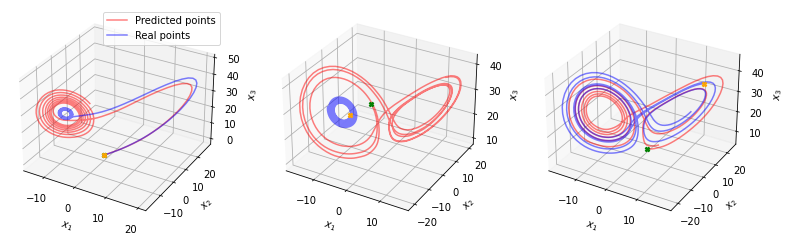

In [25]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
ax = fig.add_subplot(1, 3, 2, projection='3d')
MIN , MAX = 600, 1200 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax = fig.add_subplot(1, 3, 3, projection='3d')
MIN , MAX = 3200, 3800 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")

#fig.suptitle("Learning Lorenz'63",fontsize=15)

fname="./figs/fehlberg_lorenz_3.pdf"
savefig(fname, format="pdf")

./figs/fehlberg_lorenz_3.pdf already exists. Move it or change the file name


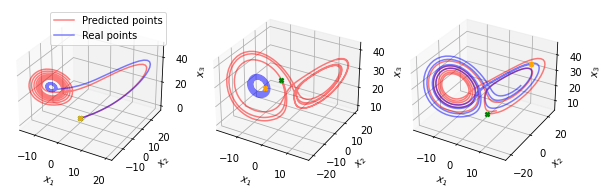

In [26]:
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
ax = fig.add_subplot(1, 3, 2, projection='3d')
MIN , MAX = 600, 1200 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax = fig.add_subplot(1, 3, 3, projection='3d')
MIN , MAX = 3200, 3800 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")

#fig.suptitle("Learning Lorenz'63",fontsize=15)


fname="./figs/fehlberg_lorenz_3.pdf"
savefig(fname, format="pdf")

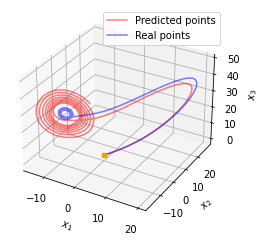

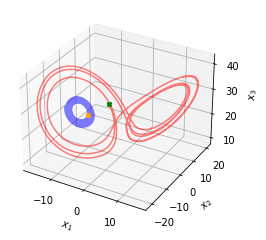

Save fig in fehlberg_lorenz_3_3.pdf


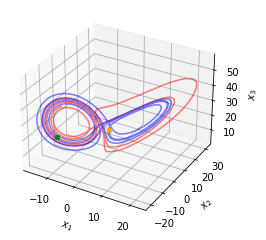

In [27]:
ax = plt.axes(projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
plt.savefig("baseline_lorenz_1_3.pdf", format="pdf")
plt.show()
ax = plt.axes(projection='3d')
MIN , MAX = 600,1200 
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
plt.savefig("baseline_lorenz_2_3.pdf", format="pdf")
plt.show()
ax = plt.axes(projection='3d')
MIN , MAX = 2000,2600
_ = ax_3D(ax,ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="")
savefig("./figs/fehlberg_lorenz_3_3.pdf", format="pdf")

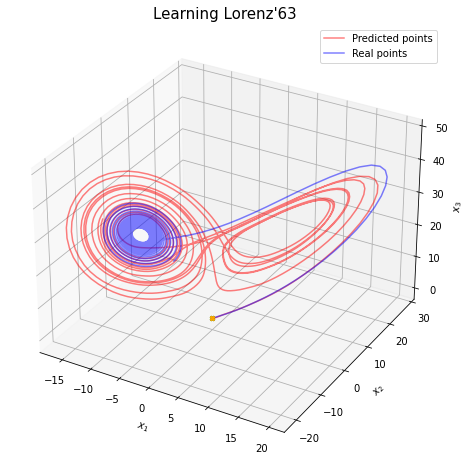

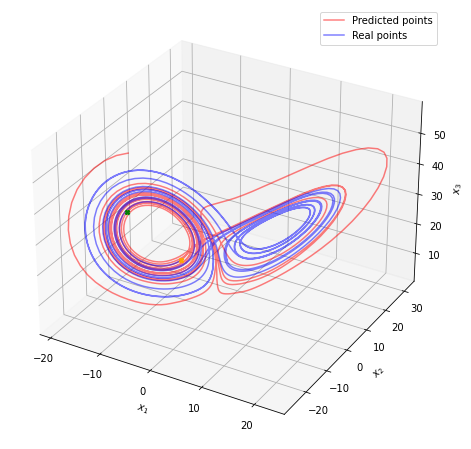

In [28]:
MIN , MAX = 0 , 1500 
plot3D_compare(ztrain[MIN:MAX],data[MIN:MAX],markers=False, title="Learning Lorenz'63")
MIN , MAX = 1500 , 3000 
plot3D_compare(ztrain[MIN:MAX],data[MIN:MAX],markers=False)


In [29]:
genlo = LorenzMap(delta_t=1e-4)
#orgrec = model_recover(data,genlo)
rec = model_recover(ztrain,genlo)


Save fig in ./figs/fehlberg_time_series.pdf


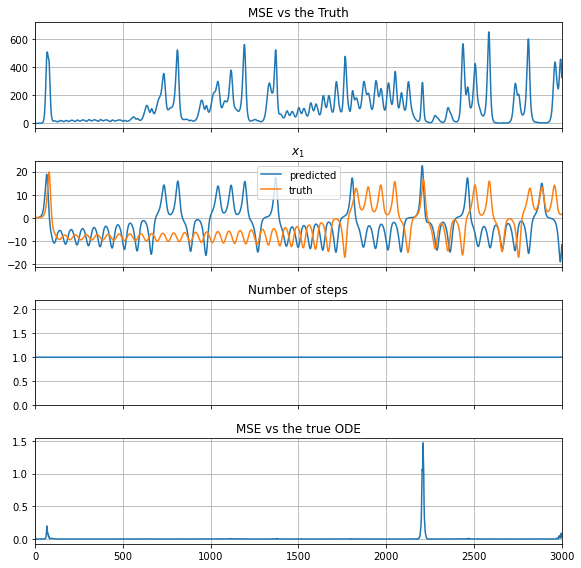

In [30]:
err = error_in_time(ztrain,data)
MIN , MAX = 0,3000
fig , axs = plt.subplots(4,1,figsize=(8,8),sharex=True)
axs[0].plot(err/3,label="MSE")
axs[0].set_title("MSE vs the Truth")

axs[1].plot(ztrain[:,0],label="predicted")
axs[1].plot(data[:,0],label="truth")
axs[1].legend()
axs[1].set_title("$x_1$")


axs[2].plot(steps,label="number of steps")
axs[2].set_ylim(0,2.2)
axs[2].set_title("Number of steps")

err2 = error_in_time(ztrain,rec)
axs[3].plot(err2/3,label="MSE")
axs[3].set_title("MSE vs the true ODE")
fig.tight_layout()
for ax in axs:
    ax.grid()
    ax.set_xlim(MIN,MAX)
    
fname="./figs/fehlberg_time_series.pdf"
savefig(fname, format="pdf")

Save fig in ./figs/fehlberg_time_series_2x2.pdf


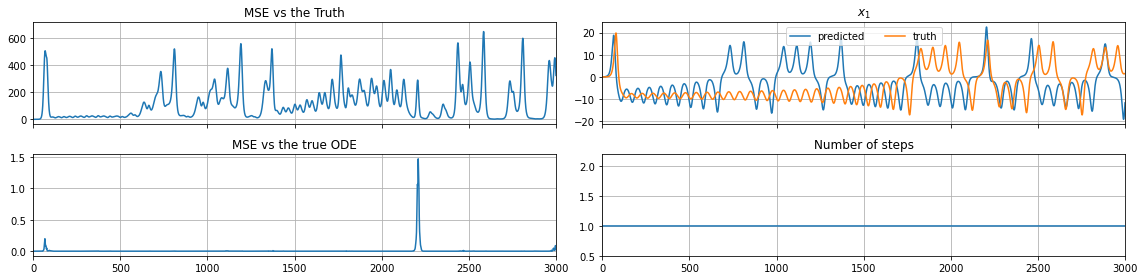

In [31]:
err = error_in_time(ztrain,data)
MIN , MAX = 0,3000
fig , axs = plt.subplots(2,2,figsize=(16,4),sharex=True)
axs[0,0].plot(err/3,label="MSE")
axs[0,0].set_title("MSE vs the Truth")
axs[0,0].set_xlim(MIN,MAX)

axs[1,1].plot(steps,label="number of steps")
axs[1,1].set_ylim(0.5,2.2)
axs[1,1].set_title("Number of steps")
    
axs[0,1].plot(ztrain[:,0],label="predicted")
axs[0,1].plot(data[:,0],label="truth")
axs[0,1].legend(ncol=2)
axs[0,1].set_title("$x_1$")



err2 = error_in_time(ztrain,rec)
axs[1,0].plot(err2/3,label="MSE")
axs[1,0].set_title("MSE vs the true ODE")

for r in axs:
    for c in r:
        c.grid()

fig.tight_layout()

fname="./figs/fehlberg_time_series_2x2.pdf"
savefig(fname, format="pdf")

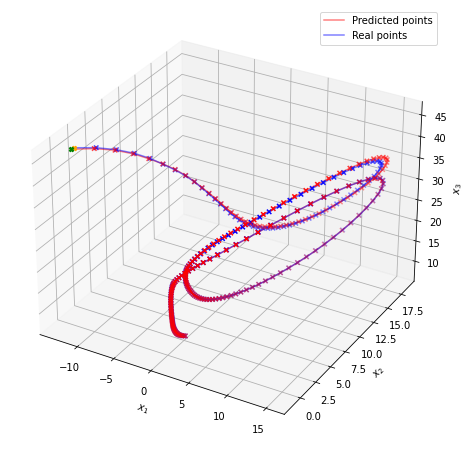

In [32]:
plot3D_compare(ztrain[3000:3200],rec[3000:3200],markers=True)


Save fig in ./figs/fehlberg_vs_recover_0_to_20.pdf


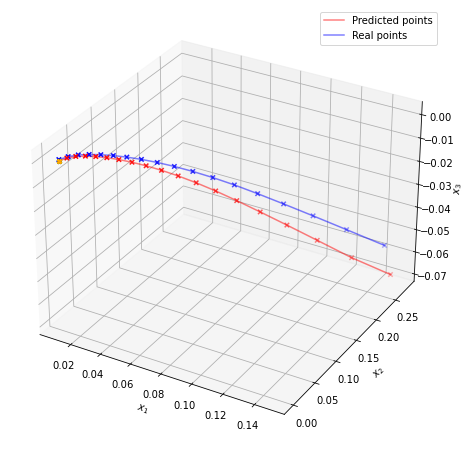

Save fig in ./figs/fehlberg_vs_data_0_to_20.pdf


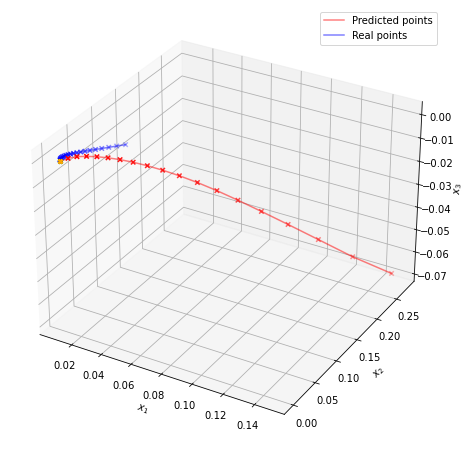

Save fig in ./figs/fehlberg_vs_recover_1000_to_1100.pdf


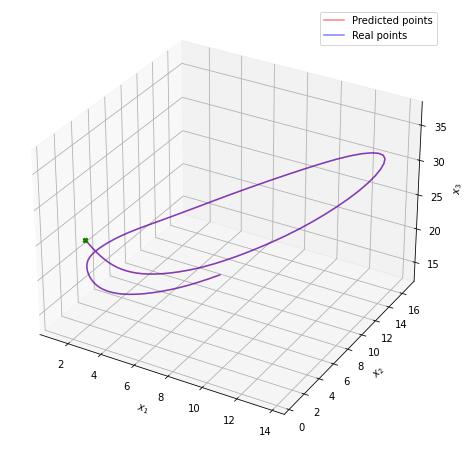

Save fig in ./figs/fehlberg_vs_recover_4500_to_4600.pdf


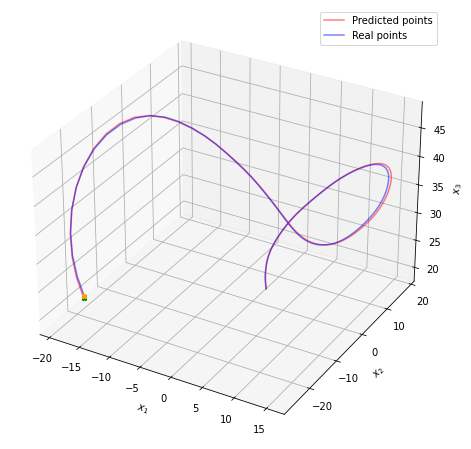

In [33]:
plot3D_compare(ztrain[:20],rec[:20],markers=True)
savefig("./figs/fehlberg_vs_recover_0_to_20.pdf", format="pdf")
plt.show()

plot3D_compare(ztrain[:20],data[:20],markers=True)
savefig("./figs/fehlberg_vs_data_0_to_20.pdf", format="pdf")
plt.show()

plot3D_compare(ztrain[1000:1100],rec[1000:1100])
savefig("./figs/fehlberg_vs_recover_1000_to_1100.pdf", format="pdf")
plt.show()

plot3D_compare(ztrain,rec,4500,4600)
savefig("./figs/fehlberg_vs_recover_4500_to_4600.pdf", format="pdf")
plt.show()
